In [46]:
import json
import pprint
import json

import os
import numpy as np
import cv2
from PIL import Image
from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline

import torch.utils.data as data
from utils.data_augumentation import Compose, get_anno, add_neck, aug_scale, aug_rotate, aug_croppad, aug_flip, remove_illegal_joint, Normalize_Tensor, no_Normalize_Tensor
from utils.dataloader import get_ground_truth


# 画像、マスク画像、アノテーションデータへのファイルパスリストを作成

In [37]:
def make_datapath_list(rootpath):
    # アノテーションのJSONファイルを読み込む
    json_path = os.path.join(rootpath, 'COCO.json')
    with open(json_path) as data_file:
        data_this = json.load(data_file)
        data_json = data_this['root']
    
    # indexを格納
    num_samples = len(data_json)
    train_indexes = []
    val_indexes = []
    
    for count in range(num_samples):
        # 検証データのインデックス番号を加える
        if data_json[count]['isValidation'] != 0:
            val_indexes.append(count)
            
        else:
            train_indexes.append(count)
            
    # 画像ファイルパスを格納
    train_img_list = list()
    val_img_list = list()
    
    for idx in train_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        train_img_list.append(img_path)
        
    for idx in val_indexes:
        img_path = os.path.join(rootpath, data_json[idx]['img_paths'])
        val_img_list.append(img_path)
        
    # マスクデータのパスを格納
    train_mask_list = []
    val_mask_list = []

    for idx in train_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = './data/mask/train2014/mask_COCO_train2014_' + img_idx + '.jpg'
        train_mask_list.append(anno_path)
        
    for idx in val_indexes:
        img_idx = data_json[idx]['img_paths'][-16:-4]
        anno_path = "./data/mask/val2014/mask_COCO_val2014_" + img_idx+'.jpg'
        val_mask_list.append(anno_path)
        
    # アノテーションデータを格納
    train_meta_list = list()
    val_meta_list = list()
    
    for idx in train_indexes:
        train_meta_list.append(data_json[idx])

    for idx in val_indexes:
        val_meta_list.append(data_json[idx])

    return train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list

In [32]:
json_path = osp.join('data', 'COCO.json')
with open(json_path) as data_file:
    data_this = json.load(data_file)
    data_json = data_this['root']

print(data_json[0])
print(data_json[1]['img_paths'][-16:-4])

{'dataset': 'COCO', 'isValidation': 0.0, 'img_paths': 'train2014/COCO_train2014_000000000036.jpg', 'img_width': 481.0, 'img_height': 640.0, 'objpos': [322.885, 395.485], 'image_id': 36.0, 'bbox': [167.58, 162.89, 310.61, 465.19], 'segment_area': 86145.297, 'num_keypoints': 13.0, 'joint_self': [[250.0, 244.0, 1.0], [265.0, 223.0, 1.0], [235.0, 235.0, 1.0], [309.0, 227.0, 1.0], [235.0, 253.0, 1.0], [355.0, 337.0, 1.0], [215.0, 342.0, 1.0], [407.0, 494.0, 1.0], [213.0, 520.0, 1.0], [445.0, 617.0, 1.0], [244.0, 447.0, 1.0], [338.0, 603.0, 1.0], [267.0, 608.0, 1.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0], [0.0, 0.0, 2.0]], 'scale_provided': 1.264, 'joint_others': [], 'annolist_index': 1.0, 'people_index': 1.0, 'numOtherPeople': 0.0, 'scale_provided_other': {'_ArrayType_': 'double', '_ArraySize_': [0, 0], '_ArrayData_': None}, 'objpos_other': {'_ArrayType_': 'double', '_ArraySize_': [0, 0], '_ArrayData_': None}, 'bbox_other': {'_ArrayType_': 'double', '_ArraySize_': [0, 0], '_Arra

In [38]:
# 動作確認（実行には10秒ほど時間がかかります）
train_img_list, train_mask_list, val_img_list, val_mask_list, train_meta_list, val_meta_list = make_datapath_list(
    rootpath="./data/")

val_meta_list[24]

{'dataset': 'COCO_val',
 'isValidation': 1.0,
 'img_paths': 'val2014/COCO_val2014_000000000488.jpg',
 'img_width': 640.0,
 'img_height': 406.0,
 'objpos': [233.075, 275.815],
 'image_id': 488.0,
 'bbox': [180.76, 210.3, 104.63, 131.03],
 'segment_area': 4851.846,
 'num_keypoints': 15.0,
 'joint_self': [[266.0, 231.0, 1.0],
  [0.0, 0.0, 2.0],
  [264.0, 229.0, 1.0],
  [0.0, 0.0, 2.0],
  [256.0, 231.0, 1.0],
  [261.0, 239.0, 1.0],
  [238.0, 239.0, 1.0],
  [267.0, 259.0, 1.0],
  [222.0, 262.0, 1.0],
  [272.0, 267.0, 1.0],
  [243.0, 256.0, 1.0],
  [244.0, 278.0, 1.0],
  [229.0, 279.0, 1.0],
  [269.0, 297.0, 1.0],
  [219.0, 310.0, 1.0],
  [267.0, 328.0, 1.0],
  [192.0, 329.0, 1.0]],
 'scale_provided': 0.356,
 'joint_others': [[[0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [0.0, 0.0, 2.0],
   [174.0, 261.0, 1.0],
   [169.0, 275.0, 1.0],
   [155.0, 275.0, 1.0],
   [190.0, 282.0, 1.0],
   [142.0, 299.0, 1.0],
   [217.0, 285.0, 1.0],
   [133.0, 329.0, 1.0],
   [0.0, 0.0, 2.0],
   [

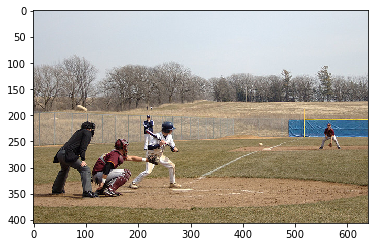

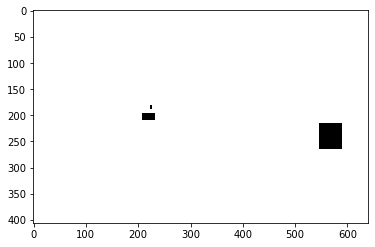

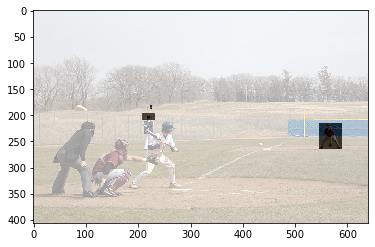

In [39]:
index = 24

# 画像
img = cv2.imread(val_img_list[index])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.show()

# マスク
mask_miss = cv2.imread(val_mask_list[index])
mask_miss = cv2.cvtColor(mask_miss, cv2.COLOR_BGR2RGB)
plt.imshow(mask_miss)
plt.show()

# 合成
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 画像の前処理作成

In [44]:
class DataTransform:
    """
    画像とマスク、アノテーションの前処理クラス。
    学習時と推論時で異なる動作をする。
    学習時はデータオーギュメンテーションする。
    """
    
    def __init__(self):
        self.data_transform = {
            'train' : Compose([
                get_anno(),  # JSONからアノテーションを辞書に格納
                add_neck(),  # アノテーションデータの順番を変更し、さらに首のアノテーションデータを追加
                aug_scale(),  # 拡大縮小
                aug_rotate(),  # 回転
                aug_croppad(),  # 切り出し
                aug_flip(),  # 左右反転
                remove_illegal_joint(),  # 画像からはみ出たアノテーションを除去
                # Normalize_Tensor()  # 色情報の標準化とテンソル化
                no_Normalize_Tensor()  # 本節のみ、色情報の標準化をなくす
            ]),
            'val' : Compose([])
        }
        
    def __call__(self, phase, meta_data, img, mask_miss):
        meta_data, img, mask_miss = self.data_transform[phase](
        meta_data, img, mask_miss)

        return meta_data, img, mask_miss

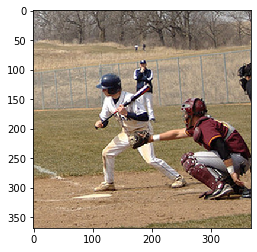

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


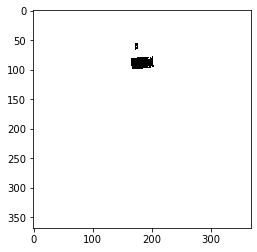

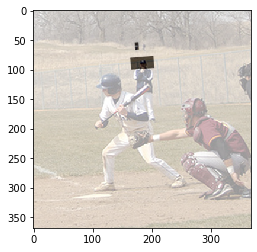

In [45]:
# 動作確認
# 画像読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 画像前処理
transform = DataTransform()
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

# 画像表示
img = img.numpy().transpose((1, 2, 0))
plt.imshow(img)
plt.show()

# マスク表示
mask_miss = mask_miss.numpy().transpose((1, 2, 0))
plt.imshow(mask_miss)
plt.show()

# 合成 RGBにそろえてから
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))
mask_miss = Image.fromarray(np.uint8((mask_miss)))
mask_miss = np.asarray(mask_miss.convert('RGB'))
blend_img = cv2.addWeighted(img, 0.4, mask_miss, 0.6, 0)
plt.imshow(blend_img)
plt.show()


# 訓練データの正解情報として使うアノテーションデータの作成

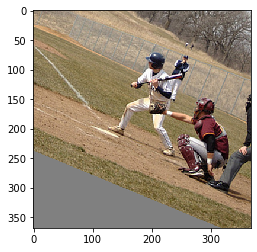

In [49]:
# 画像読み込み
index = 24
img = cv2.imread(val_img_list[index])
mask_miss = cv2.imread(val_mask_list[index])
meat_data = val_meta_list[index]

# 画像前処理
meta_data, img, mask_miss = transform("train", meat_data, img, mask_miss)

img = img.numpy().transpose((1, 2, 0))
mask_miss = mask_miss.numpy().transpose((1, 2, 0))

# OpenPoseのアノテーションデータ生成
heat_mask, heatmaps, paf_mask, pafs = get_ground_truth(meta_data, mask_miss)

# 画像表示
plt.imshow(img)
plt.show()

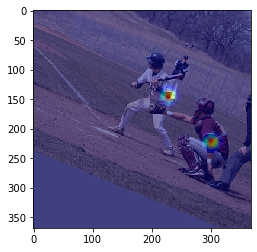

In [50]:
# 左肘のheatmapを確認

# 元画像
img = Image.fromarray(np.uint8(img*255))
img = np.asarray(img.convert('RGB'))

# 左肘
heat_map = heatmaps[:, :, 6]  # 6は左肘
heat_map = Image.fromarray(np.uint8(cm.jet(heat_map)*255))
heat_map = np.asarray(heat_map.convert('RGB'))
heat_map = cv2.resize(
    heat_map, (img.shape[1], img.shape[0]), interpolation=cv2.INTER_CUBIC)
# 注意：heatmapは画像サイズが1/8になっているので拡大する

# 合成して表示
blend_img = cv2.addWeighted(img, 0.5, heat_map, 0.5, 0)
plt.imshow(blend_img)
plt.show()
